## World Series Winners: An Exploration!
_Ravi Dayabhai_

<img style="float: left;" src="http://a.espncdn.com/media/motion/2013/1024/dm_131024_mlb_olbermann_why_nobody_watches_world_series/dm_131024_mlb_olbermann_why_nobody_watches_world_series.jpg" />
<img style="float: left; height: 324px; margin: 0px 0px 0px 15px" src="http://media.bizj.us/view/img/1721981/tom-glavine-12*750xx1800-2400-147-0.jpg" />

To begin, I ask a simple question: **What do various "profiles" of World Series teams throughout history look like?**

In [1]:
# Import all the modules used in the subsequent analysis

import glob
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 0. Import data into a dictionary of dataframes ###
filename_list = glob.glob('*.csv')
data_dict = {f[:-4]: pd.read_csv(f) for f in filename_list}

To answer this question, we begin our data adventure by importing not only all of the modules needed for this project, but the data set itself! I chose to store all of the data as Pandas DataFrames, all of which were then stored as values in a dictionary. The dictionary (`data_dict`) keys were the original file names of the \*.CSVs.

I began by adding a few more composite metrics such as WHIP and slugging percentage to beef up the existing data. It can be argued that these added metrics do a better job capturing a given teams defensive, offensive, or pitching prowess. Unfortunately, as will be seen later, some statistics (e.g., sacrifice flies) did not span the entire history of baseball and resulted in `NaN`s for these composite metrics for relatively earlier dated data (e.g., years before 2000).

In [2]:
### 1. Rankings of WS-winning Teams ###

## 1.1 Adding compound team metrics ##

# On-base Percentage, "OBP"
data_dict["Teams"]["OBP"] = (data_dict[
    "Teams"]["H"] + data_dict[
        "Teams"]["BB"] + data_dict[
            "Teams"]["HBP"]) / (data_dict[
                "Teams"]["AB"] + data_dict[
                    "Teams"]["SF"] + data_dict[
                        "Teams"]["BB"] + data_dict[
                            "Teams"]["HBP"])

# Slugging Percentage, "SLG"
TB_weights = pd.DataFrame([1, 2, 3, 4], index=['S', '2B', '3B', 'HR'])
data_dict["Teams"]["S"] = data_dict["Teams"][
    "H"] - data_dict["Teams"].ix[:, "2B": "HR"].sum(axis=1)

new_col_list = ['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', 'S', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS',
                'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro', 'OBP']

data_dict["Teams"] = data_dict["Teams"][new_col_list]

data_dict["Teams"]["TB"] = data_dict["Teams"].ix[:, "S":"HR"].dot(TB_weights)

data_dict["Teams"]["SLG"] = data_dict["Teams"]["TB"] / data_dict[
    "Teams"]["AB"]

# On-base plus slugging, "OPS"
data_dict["Teams"]["OPS"] = data_dict[
    "Teams"]["OBP"] + data_dict["Teams"]["SLG"]

# Team Batting Average, "teamBA"
data_dict["Teams"]["teamBA"] = data_dict[
    "Teams"]["H"] / data_dict["Teams"]["AB"]

# Walks plus hits per inning pitched, "WHIP"

data_dict["Teams"]["WHIP"] = (data_dict["Teams"][
                              "BBA"] + data_dict["Teams"]["HA"]) / (data_dict["Teams"]["IPouts"] / 3)

# Making WSWin column summarizable
data_dict["Teams"].replace({'WSWin': {'Y': 1, 'N': 0}}, inplace=True)

In [3]:
## Computing average age of teams per year ##

# Create dataframe of all players on each team in each year; player might
# show up on 2+ different teams in a given year
tables_of_players = ["Batting", "Pitching", "Fielding"]
tables_to_merge = []
for table in tables_of_players:
    df = data_dict[table]
    tables_to_merge.append(df.groupby(
        ["yearID", "teamID", "playerID"]).mean())

all_players_byteam = reduce(lambda left, right: pd.merge(
    left, right, left_index=True, right_index=True, how="outer"), tables_to_merge)

all_players_byteam.reset_index(inplace=True)
all_players_byteam = all_players_byteam[["yearID", "teamID", "playerID"]]
player_info = data_dict["Master"]
age_df = all_players_byteam.merge(
    player_info[["playerID", "birthYear"]], on="playerID")
age_df["age"] = age_df["yearID"] - age_df["birthYear"]

# Players with missing 'birthYear's == 130
# missing_age_info = age_df[age_df.isnull().birthYear]
# print len(set(missing_age_info.playerID))

# Add "age" column to "Teams" table
grouped_Ages = age_df.groupby(["yearID", "teamID"]).mean()[["age"]]
grouped_Teams = data_dict["Teams"].groupby(["yearID", "teamID"]).mean()
team_summary_per_year = grouped_Teams.merge(
    grouped_Ages, left_index=True, right_index=True, how="inner")

In [4]:
### 1.2 Assemble dataframe of rankings for selected statistics ###

# Begin exploring where the WS team falls in distribution for various
# statistics vs. competitors in a given year ###

## Ignore RuntimeWarning: invalid value when computing percentiles ##
np.seterr(divide='ignore', invalid='ignore')

def pctile_calc(x):
    return [stats.percentileofscore(x, a, 'mean') for a in x]


def zscore(x):
    return stats.zscore(x)


def stdizer(df, names, *args):
    std_tables = {}
    name_picker = 0
    for f in args:
        temp_dic = {}
        for year in set(team_summary_per_year.index.get_level_values("yearID")):
            df_temp = df.loc[year].apply(f)
            df_temp["yearID"] = [year for teams in df_temp.index.values]
            temp_dic[year] = df_temp.reset_index().groupby(
                ["yearID", "teamID"]).max()
        std_tables[names[name_picker]] = pd.concat(list(temp_dic.values()))
        name_picker += 1
    return std_tables


std_tables_names = ["percentiles", "zscores"]
std_data_library = stdizer(team_summary_per_year,
                           std_tables_names, pctile_calc, zscore)
zscores_wswinners = std_data_library["zscores"].reset_index().groupby("yearID").apply(
    lambda x: x.sort_values("WSWin", ascending=False).head(1)).set_index(["yearID", "teamID"])

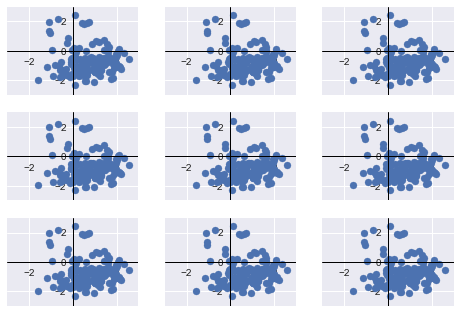

In [5]:
### 1.3 Charting of pairwise comparisons ###

stats_of_interest = ["R", "H", "teamBA",
                     "SLG", "OBP", "OPS", "SB", "RA", "ERA", "HA", "SO", "BBA", "age"]

# Experimenting by creating 1 pairwise scatter plot(quadrant delineation important!)
fig = plt.figure()                                                   
for i in range(1, 10):
    x = zscores_wswinners["teamBA"]
    y = zscores_wswinners["ERA"]

    ax = fig.add_subplot(3,3,i)
    ax.scatter(x, y)
    plot_axes_range = [-3, 3, -3, 3]
    ax.axis(plot_axes_range, 'equal')

    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')

plt.show()